<img src=" " height="500" width="500"> 

# <center> ML для маркетинга. <br>  <br> Cюжетная арка 3: сегментация </center>

В этом семестре мы с вами пройдём через несколько сюжетных арок. Третьей и заключительной такой аркой будет сегментация. 


#  Глава I (Люси заглядывает в платяной шкаф) 

Интуитивная постановка задачи кластеризации довольно проста и представляет из себя наше желание сказать: "Вот тут у меня насыпаны точки. Я вижу, что они сваливаются в какие-то кучки вместе. Было бы круто иметь возможность эти точки относить к кучкам и в случае появления новой точки на плоскости говорить, в какую кучку она падает." Из такой постановки видно, что пространства для фантазии получается много, и от этого возникает соответствующее множество алгоритмов решения этой задачи.

![](https://habrastorage.org/getpro/habr/post_images/8b9/ae5/586/8b9ae55861f22a2809e8b3a00ef815ad.png)

Как обычно, начнём нашу тетрадку с подгрузки необходимых пакетов.

In [1]:
import pandas as pd    # пакет для работы с таблицами 
import numpy as np     # пакет для работы с матрицами 

# пакеты для картиночек 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # правильный (наиболее красивый) стиль у графиков

%matplotlib inline

Пробовать сегментацию на вкус будем на вас. Не забыли, что у нас с прошлого семестра есть ваши данные по vk? 

In [2]:
df = pd.read_csv('vk_main.csv', sep='\t')
df.head()

,city,country,first_name,home_town,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Артём,MOSCOW,Еркин,0,181029517,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,16.0,0.375000
1,NaN,Россия,Армен,NaN,Хачатрян,15,73703994,1,0,1,...,1.750000,4.0,1.0,0.571429,1.0,0.0,0.0,0.0,47.0,0.531915
2,Москва,Россия,Abbos,Бекабад,Akhmedov,11,467673028,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,26.0,0.500000
3,Москва,Россия,Адам,NaN,Триандафилиди,0,144910934,1,0,1,...,1.428571,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,83.0,0.518072
4,Алматы,Казахстан,Айжан,NaN,Саят,9,166045266,0,0,0,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,29.0,0.344828


Сколько у нас наблюдений? 

In [3]:
df.shape

(335, 96)

Оставим только числовые данные. Все пропуски для простот ызаполним нулями. 

In [4]:
X = df.select_dtypes(include=['int', 'float']).drop('uid', axis=1).fillna(0)

# запомним имена колонок
features = X.columns
X.shape

(335, 83)

В отдельный вектор положим имена и фамилии. Тоже для удобства. 

In [5]:
names = (df.first_name + ' ' + df.last_name).get_values()
names[:20]

array(['Артём Еркин', 'Армен Хачатрян', 'Abbos Akhmedov',
       'Адам Триандафилиди', 'Айжан Саят', 'Alina Kobets',
       'Алена Иванова', 'Алена Бальзамова', 'Саша Ковалёв',
       'Александра Шаруба', 'Александра Радкевич', 'Сандрик Рухадзе',
       'Саид Алиев', 'Алина Губкина', 'Алина Карпулова',
       'Алина Плетминцева', 'Alisa Artemieva', 'Алишер Халдаров',
       'Алёна Богданова', 'Анастасия Семёнова'], dtype=object)

Все переменные отскалируем. Надеюсь, что вы ещё не забыли, что это делается для устройчивости работы алгоритмов. Чтобы метрики не путались, и чтобы градиентный спуск почём зря не блуждал. 

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## 1. TSNE

Вот бы начать с того, чтобы нарисовать те данные, которые есть у нас в табличке! Жалко, что там целых $83$ столбца и это невозможно. Или .... возможно? 

В $2008$ году умные мужи придумали алгоритм TSNE. С его помощью можно нарисовать данные любой размерности на двумерной плоскости так, чтобы их внутренняя структура сохранилась. 

Это работает примерно так. Представьте себе новое модное морожное из шариков. 

![ ](https://i01.fotocdn.net/s113/5d7e77474b917a41/public_pin_l/2550262005.jpg) 

Давайте вытащим это морожное из баночки и слепим из него снежок. Каждый шарик это наше наблюдение в трёхмерном пространстве. Когда мы слепили шарик, какие-то из наблюдений сильно прилипли друг к другу, какие-то слабо. Где-то морожное подтаяло. 

Теперь давайте размахнёмся и кинем морожное в стенку. Его здорово расплющит, а шарики разлетятся по стене. При этом, если шарики были в большом комке сильно слиплены, они не разлетяться. Мы перевели наш трёхмерный шарик в двумерное пространство, в ... стену. 

Трёхмерный мир для слабаков. Наша табличка с данными находится в $83$-мерном мире. Давайте как следует кинем её в стену и посмотрим что получится. То, насколько сильно мы кидаем табличку в стену, регулирует параметр `perplexity`.

In [7]:
from sklearn.manifold import TSNE

# random state мы ставим, чтобы картинка каждый раз была одинаковой
# perplexity (спутанность) это наш заказ на силу броска

tsne = TSNE(random_state=17, perplexity=5)
tsne_representation = tsne.fit_transform(X_scaled)

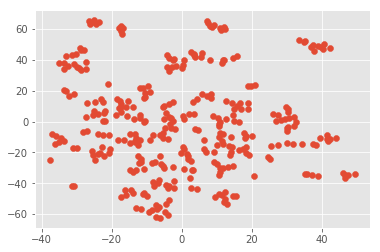

In [8]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]);

У нас получилось нарисовать наши данные. Мы видим, что в них есть какая-то структура из кластеров. Почему точки разбились именно на такие кластеры, мы не знаем. TSNE невозможно проинтерпретировать. Но зато мы можем посмотреть кто попал в какой кластер и немного пофантизировать. 

In [9]:
# интересно, что же объединяет этих людей... 
names[(tsne_representation[:,0] > 40)&(tsne_representation[:,1] < -20)]

array(['Виктория Лебедева', 'Максим Пантелеев', 'Анастасия Рековец',
       'Лиля Сабитова', 'Лена Лазарева'], dtype=object)

In [10]:
names[(tsne_representation[:,0] > 20)&(tsne_representation[:,1] > 40)]

array(['Дмитрий Бурмистров', 'Тимур Трубчанинов', 'Mikhail Pashentsev',
       'Дмитрий Русин', 'Лена Тумашкова', 'Полина Змушко',
       'Маша Александрова', 'Ariana Hrustaleva', 'Вячеслав Мельник',
       'Володя Порядин', 'Владимир Синяев'], dtype=object)

## 2. K-means

Алгоритм работает так: 

1. Выбрать количество кластеров $k$, которое нам кажется оптимальным для наших данных.
2. Высыпать случайным образом в пространство наших данных $k$ точек (центры).
3. Для каждой точки нашего набора данных посчитать, к какому центру она ближе.
4. Переставить центры.
5. Делать последние два шага пока не надоест.

С шаурмой сами сопоставите :) 

In [11]:
from sklearn.cluster import KMeans       # сама модель

kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [12]:
kmeanModel.labels_

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

Давайте попробуем посмотреть на TSNE-картинке кто попал в какой кластер по k-means!

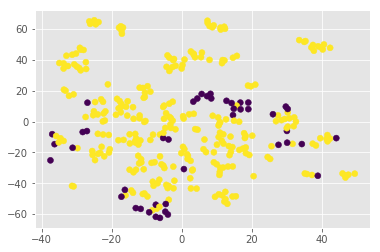

In [13]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=kmeanModel.labels_);

Можно посмотреть чем именно получившиеся группы отличаются друг от друга. 

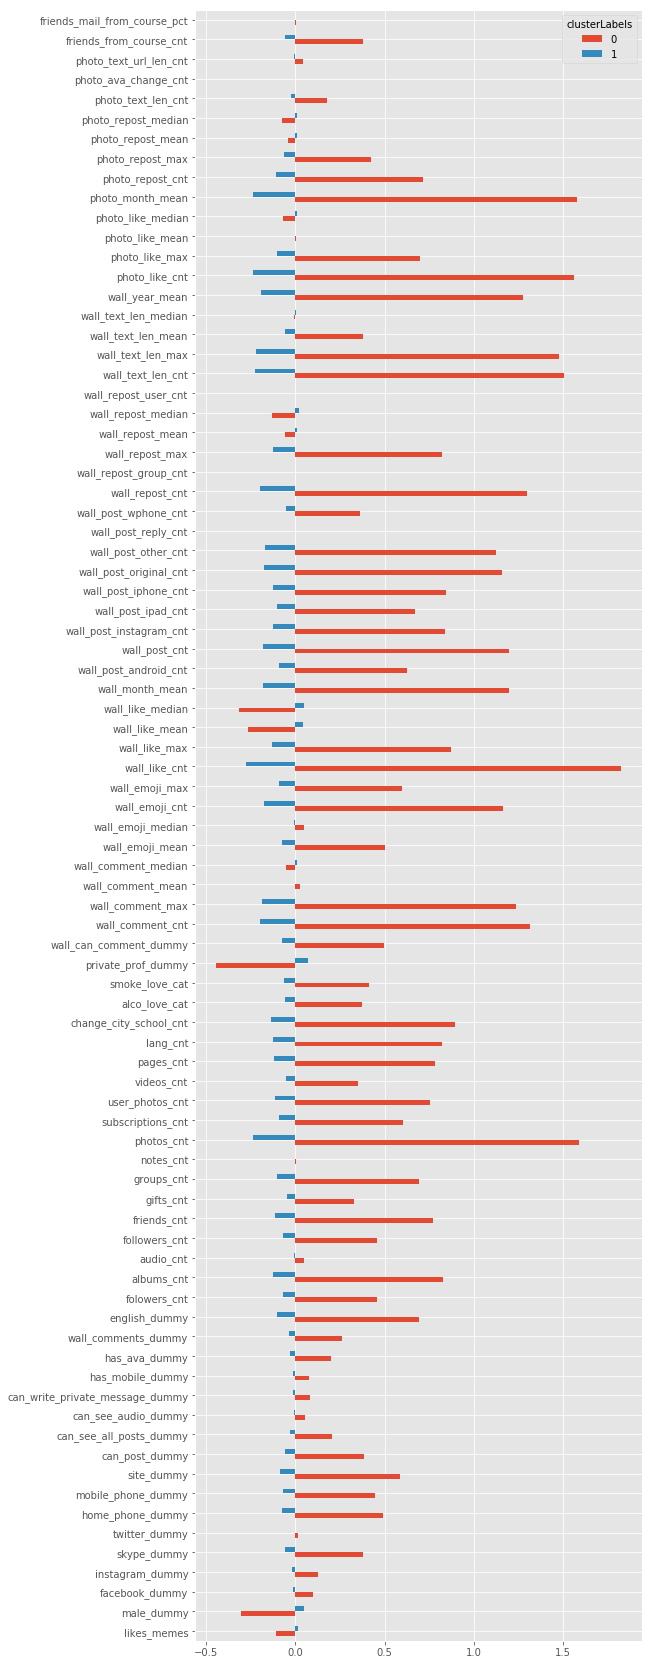

In [14]:
df_scaled = pd.DataFrame(X_scaled)
df_scaled.columns = features

df_scaled['clusterLabels'] = kmeanModel.labels_

# из-за того, что фичей много картинка окажется длиииинной :) 
df_scaled.groupby('clusterLabels').mean().T.plot.barh(figsize=(8, 30));

Число кластеров в k-means можно пытаться подбирать. Но тут будут небольшие проблемы.

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации.
В случае kMeans распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.

$$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

здесь $C$ – множество кластеров мощности $K$, $\mu_k$ – центроид кластера $C_k$.

__Здравый смысл в этом есть:__ мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого фнукционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).

Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". 

In [16]:
from sklearn.cluster import KMeans       # сама модель
from sklearn import metrics              # куда ж мы без метрик
from scipy.spatial.distance import cdist # функция для рассчета расстояний между парами точек

# будем искать оптимальное k
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_scaled)
    inertia.append(np.sqrt(kmeans.inertia_))

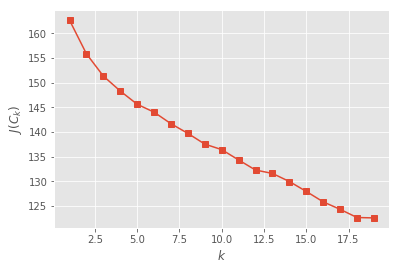

In [17]:
plt.plot(range(1, 20), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

В нашем случае такой точки нет... :(

## 3. Агломеративная или иерархическая кластеризация

1. Начинаем с того, что высыпаем на каждую точку свой кластер
2. Сортируем попарные расстояния между центрами кластеров по возрастанию
3. Берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера
4. Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер


По итогам выполнения такого алгоритма можно построить замечательное дерево склеивания кластеров и глядя на него определить, на каком этапе нам было бы оптимальнее всего остановить алгоритм. Либо воспользоваться тем же правилом локтя, что и в k-means.

In [33]:
from sklearn.cluster import AgglomerativeClustering

# linkage — конкретная реализация алгоритма
cluster = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='ward')
cluster.fit(X_scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=20,
            pooling_func='deprecated')

Посмотрим на получившееся дерево склеек!

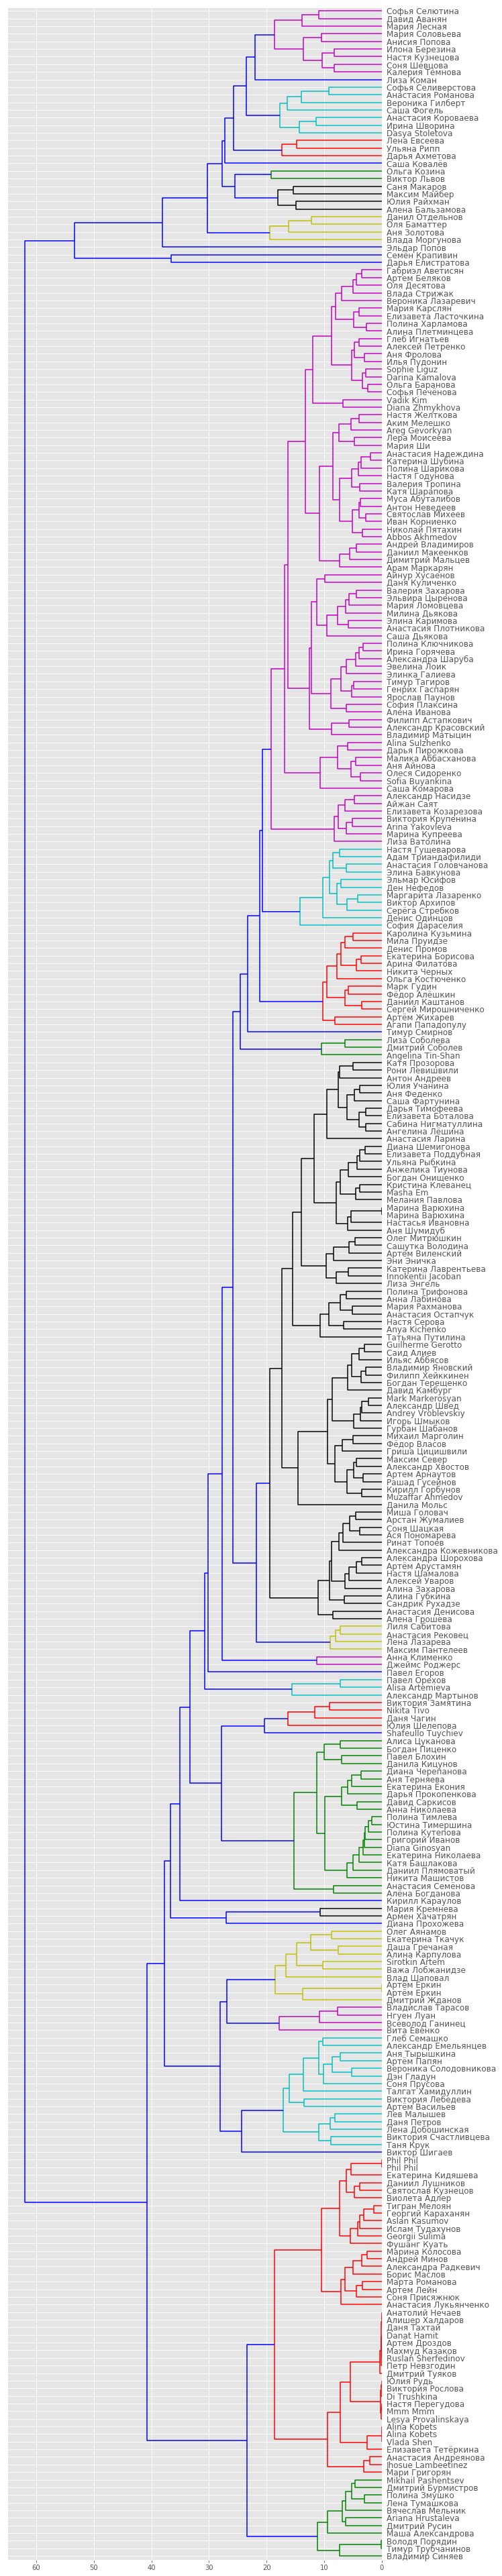

In [34]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

distance_mat = pdist(X_scaled) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

plt.figure(figsize=(10, 70))
Z = hierarchy.linkage(distance_mat, method='ward') # linkage — реализация агломеративного алгоритма
dend = hierarchy.dendrogram(Z, color_threshold=20, labels=names, leaf_font_size=12., orientation='left')

Можно снова попыться понять как именно выделившиеся сегменты отличаются друг от друга.  Но тут из-за большого числа кластеров картинка окажется не очень понятной. 

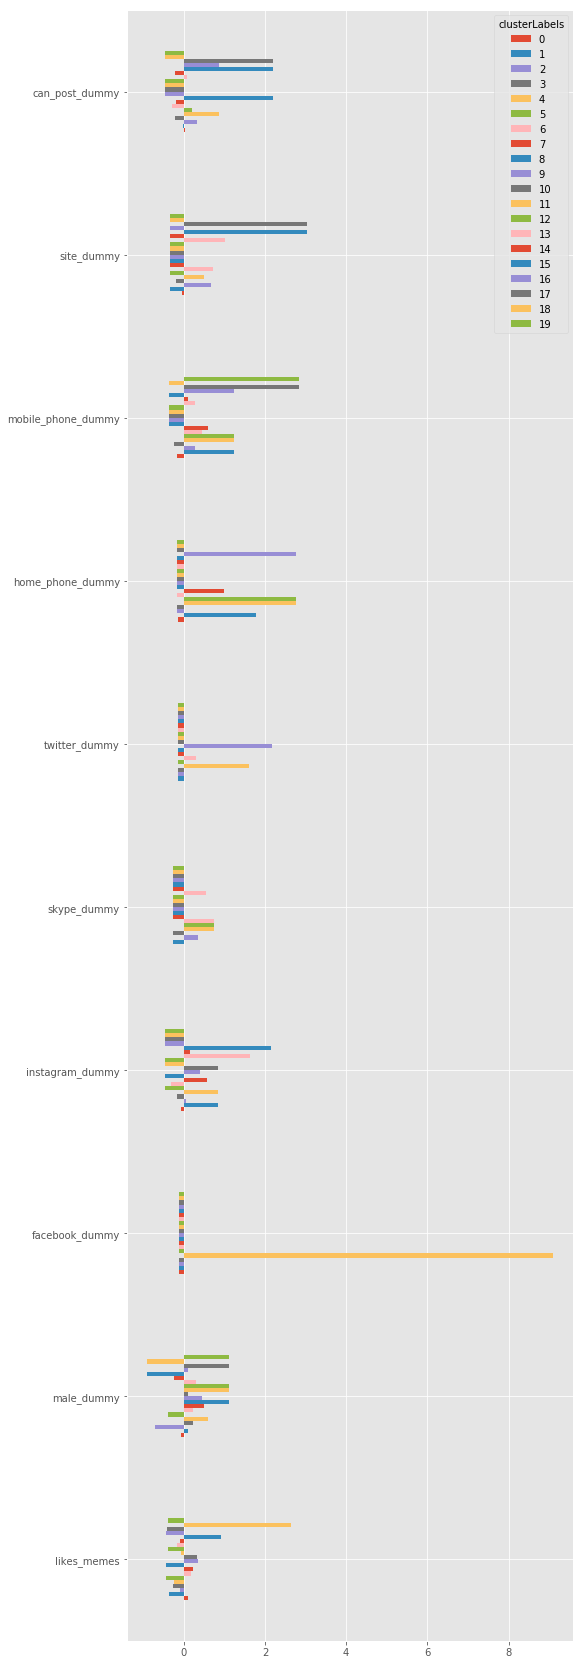

In [51]:
df_scaled = pd.DataFrame(X_scaled)
df_scaled.columns = features

df_scaled['clusterLabels'] = cluster.labels_

# из-за того, что фичей много картинка окажется длиииинной :) 
df_scaled.groupby('clusterLabels').mean().T[:10].plot.barh(figsize=(8, 30));

## 4. Текстовая информация 

Ничто не красит пользователя так, как паблики, на которые он подписан!

In [69]:
df = pd.read_csv('vk_data_wall.csv', sep='\t')
X_text = df.wall_text.fillna('').get_values()

text = X_text[1]
text

'  Давай воровать арбузы.         привет !!!!!!!!!:) у меня родился племяник Я временный Армянский армянин!!!!!!!!!!!!!  24.04.1915-мы не забудем!!!!!  Зашёл на страницу гони косарь!!      Вопрос: Кто более пунктуален? По-моему последняя порция "Водка" вчера была лишней ;-) Заходи похмелиться! Говорят, ты еще не играл в эту игру! здарова как дела???? здорова чуваки!!!!'

In [70]:
# Каждый текст это вся стенка пользователя! 
X_text.shape, len(names)

((335,), 335)

Перед тем как строить по корпусу из текстов каки-либо модели, нужно превратить тексты в цифры. Математика работает только с цифрами, а кластеризация ещё та математика.

Обычно с текстами делают несколько предобрабатывательских штук: 

1. Разбивают предложение на отдельные слова, токены. Это называется токенизацией.
2. Приводят все слова к нормальной форме (единственное число, именительный падеж и тп). Это называется лемматизацией. Её обычно делают по словарям. 
3. Выкидывают мусорные символы, понижают регистр. Выкидывают стоп-слова (предлоги и тп), очень редкие слова. 

Делают любые другие логичные манипуляции. Если нужно сделать такую предобработку быстро и без заморчоек, поможет яндексовая библиотека `Mystem`.

### pymystem3

**pymystem3** — это питоновская обертка для яндексовского морфологичекого анализатора Mystem. Его можно скачать отдельно и использовать из консоли.

* [Документация Mystem](https://tech.yandex.ru/mystem/doc/index-docpage/)
* [Документация pymystem3](http://pythonhosted.org/pymystem3/)

Инициализируем Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

In [71]:
from pymystem3 import Mystem

m = Mystem()
lemmas = m.lemmatize(text)
print(lemmas)

['  ', 'давать', ' ', 'воровать', ' ', 'арбуз', '.', '         ', 'привет', ' ', '!!!!!!!!!', ':) ', 'у', ' ', 'я', ' ', 'рождаться', ' ', 'племяник', ' ', 'я', ' ', 'временный', ' ', 'армянский', ' ', 'армянин', '!!!!!!!!!!!!!  ', '24.04', '.', '1915', '-', 'мы', ' ', 'не', ' ', 'забывать', '!!!!!  ', 'зайти', ' ', 'на', ' ', 'страница', ' ', 'гнать', ' ', 'косарь', '!!      ', 'вопрос', ': ', 'кто', ' ', 'более', ' ', 'пунктуальный', '? ', 'по-моему', ' ', 'последний', ' ', 'порция', ' "', 'водка', '" ', 'вчера', ' ', 'быть', ' ', 'лишний', ' ;-) ', 'заходить', ' ', 'похмеляться', '! ', 'говорить', ', ', 'ты', ' ', 'еще', ' ', 'не', ' ', 'играть', ' ', 'в', ' ', 'этот', ' ', 'игра', '!', ' ', 'здаров', ' ', 'как', ' ', 'дело', '????', ' ', 'здоровый', ' ', 'чувак', '!!!!', '\n']


Поиграемся с параметрами. 

In [72]:
m = Mystem(entire_input=False)
lemmas = m.lemmatize(text)
print(lemmas)

['давать', 'воровать', 'арбуз', 'привет', 'у', 'я', 'рождаться', 'племяник', 'я', 'временный', 'армянский', 'армянин', 'мы', 'не', 'забывать', 'зайти', 'на', 'страница', 'гнать', 'косарь', 'вопрос', 'кто', 'более', 'пунктуальный', 'по-моему', 'последний', 'порция', 'водка', 'вчера', 'быть', 'лишний', 'заходить', 'похмеляться', 'говорить', 'ты', 'еще', 'не', 'играть', 'в', 'этот', 'игра', 'здаров', 'как', 'дело', 'здоровый', 'чувак']


Функция `join` собирает слова назад в тексты

In [77]:
' '.join(lemmas)

'давать воровать арбуз привет у я рождаться племяник я временный армянский армянин мы не забывать зайти на страница гнать косарь вопрос кто более пунктуальный по-моему последний порция водка вчера быть лишний заходить похмеляться говорить ты еще не играть в этот игра здаров как дело здоровый чувак'

Сделаем то же самое со всеми текстами из нашего корпуса.

In [86]:
X_text_prep = np.array([' '.join(m.lemmatize(text)) for text in X_text])
X_text_prep[1]

'давать воровать арбуз привет у я рождаться племяник я временный армянский армянин мы не забывать зайти на страница гнать косарь вопрос кто более пунктуальный по-моему последний порция водка вчера быть лишний заходить похмеляться говорить ты еще не играть в этот игра здаров как дело здоровый чувак'

Остался последний момент: а как собственно подсчитать слова? Мы с вами на предыдущем семинаре обсуждали два способа. Давайте вспомним их.  Пусть у нас в коллекции есть два текста: 

1. Акции Газпрома выросли на 5%. Акции Сбербанка упали на 1%. 
2. Акции ВТБ выросли на 2%.

Тогда, опуская числа, мы можем сказать, что весь наш корпус содержит следующие уникальные слова: `акции, газпрома, выросли, на, сбербанка, упали, ВТБ`. Данный набор принято называть словарем корпуса. Теперь мы можем представить каждый документ в виде вектора в семимерном пространстве, где каждое измерение соответствует определенному слову из словаря. Теперь тот же самый корпус имеет следующее представление:

1. $[2;1;1;2;1;1;0]$
2. $[1;0;1;1;0;0;1]$

В питоне такую штуку позволяет сделать класс `CountVectorizer`.

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer() # объявили

# обучили
tt = CV.fit_transform(['Акции Газпрома выросли на. Акции Сбербанка упали на', 'Акции ВТБ выросли на'])
tt.toarray() # посмотрели

array([[2, 0, 1, 1, 2, 1, 1],
       [1, 1, 1, 0, 1, 0, 0]], dtype=int64)

Дальше можно учить модель.

In [83]:
# будем брать слово, если оно встретилось хотябы min_df и не так часто как  в max_df
CV = CountVectorizer(min_df=10, max_df=0.5)  

X_vect = CV.fit_transform(X_text_prep)

X_vect.shape

(335, 1195)

Выучим на этом какую-нибудь модель!

In [84]:
from sklearn.cluster import KMeans

# будем искать 10 сегментов
kmeans = KMeans(n_clusters = 10)  

kmeans.fit(X_vect)  # обучаем
clusters = kmeans.predict(X_vect) # приписываем каждому наблюдению свой кластер
clusters

array([0, 0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 2, 0, 0, 7, 0, 0, 0, 0, 0, 4, 0,
       2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8,
       0, 0, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 7, 0, 7,
       0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 7, 0, 0,
       0, 0, 2, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0,
       0, 7, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 7, 7, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 7,
       0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 8, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0,

Можно посмотреть какие слова входят в какой из кластеров :) 

(-0.5, 499.5, 499.5, -0.5)

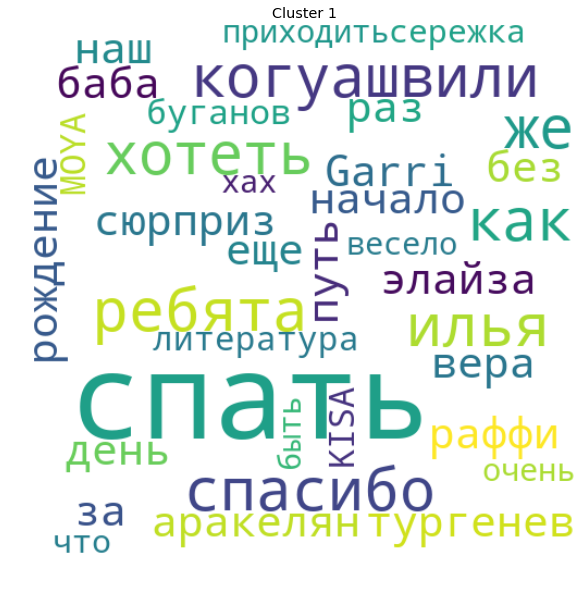

In [88]:
from wordcloud import WordCloud

cluster = 1  # для какого кластера картинка 

# генерируем облако из слов
wordcloud = WordCloud(background_color="white", max_words=500, width=500, height=500, collocations=False)
wc = wordcloud.generate(" ".join(X_text_prep[np.where(clusters==cluster)]))

# строим картинку
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Cluster {}".format(cluster))
plt.axis("off")

Пока что не очень интерпретируемо. Но в следущий раз мы посмотрим на то как можно моделировать тексты немного иначе и начнётся огонь!